<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Reviewers comment v1</h1>

Hello Andy!

I'm happy to review your project today 🙌

My name is **Gerardo Flores** and you can find me on the HUB as https://hub.tripleten.com/u/1949959f

You can find my comments under the heading **«Review»**. I will categorize my comments in green, blue or red boxes like this:

<div class="alert alert-success">
    <b>Success:</b> if everything is done successfully
</div>
<div class="alert alert-warning">
    <b>Remarks:</b> if I can give some recommendations or ways to improve the project
</div>
<div class="alert alert-danger">
    <b>Needs fixing:</b> if the block requires some corrections. Work cant be accepted with the red comments
</div>

Please don't remove my comments :) If you have any questions don't hesitate to respond to my comments in a different section. 
<div class="alert alert-info"> <b>Student comments:</b> For example like this</div>    



<div style="border:solid green 2px; padding: 20px">
<b>Reviewer's comment v1:</b>

    
<b>Overall Feedback</b>
    
Hello Andy,
    
You’ve submitted another project—great work! Your commitment to pushing through the challenges of this program is admirable.

After reviewing your submission, it is approved.
    
   
You can find my more detailed notes within your project notebook in the `Reviewer's comment v1:` section.


If you find yourself uncertain or in need of further insights, never hesitate to consult with your tutor or ask your questions here. We are here to guide and assist you.

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Reviewer's comment v1</b>
 
Great job keeping the additional information about the project goal! This information could be helpful for the notebook reader.



## Preparation

In [33]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
# looks like data is sample every 10 minutes, we will resample for 1H via sum.
df.sort_index(inplace=True)
df = data.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
# check for missing values
df.isna().sum()

num_orders    0
dtype: int64

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Reviewer's comment v1</b>
 
Great data overview!


## Analysis

Text(0.5, 1.0, 'Residuals')

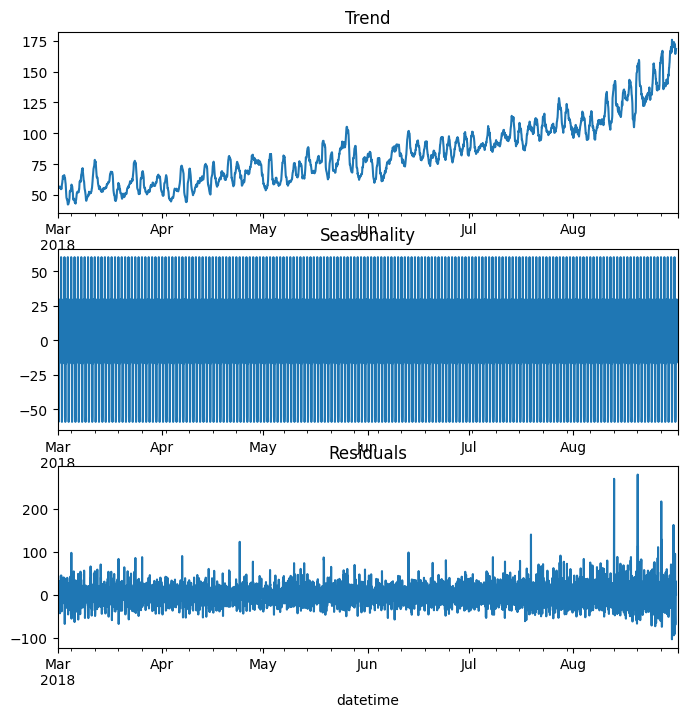

In [14]:
decomposed = seasonal_decompose(df, period=24)
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

We can see that the tread shows a smooth upward increase in taxi usage from March to August.  Seasonal plot looks like a full rectangle since we are looking at 180 days with 24 cycles per day stacked together.  It shows that taxi usage follows a strict rhythm such as higher usage during working hours and lower during nights.  Residuals plot shows decent stability with occasional spikes and anomolies, maybe due to external factors.

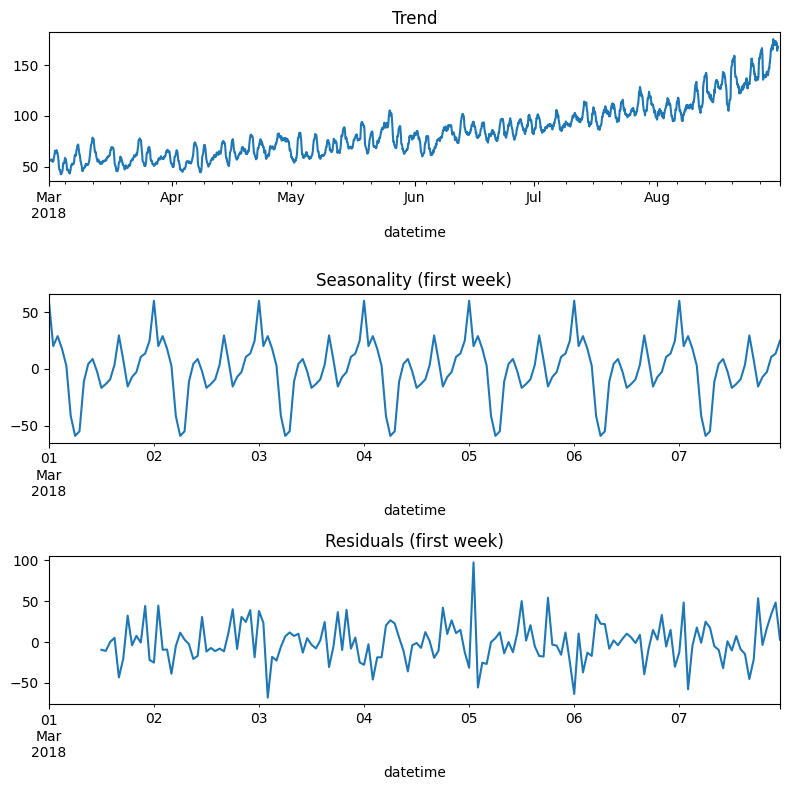

In [16]:
decomposed = seasonal_decompose(df, period=24)

plt.figure(figsize=(8, 8))

# Trend
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

# Seasonality – only first 3 days (72 hours)
plt.subplot(312)
decomposed.seasonal.iloc[:24*7].plot(ax=plt.gca())
plt.title('Seasonality (first week)')

# Residuals – same window to match
plt.subplot(313)
decomposed.resid.iloc[:24*7].plot(ax=plt.gca())
plt.title('Residuals (first week)')

plt.tight_layout()
plt.show()

Zooming into the Seasonal and Residuals plots, we can see very clear and stable rhythm with the seasonal plot.

In [27]:
# making calendar features and rolling mean
def make_features(df, max_lag=168, rolling_mean_size=24):
    # Calendar features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour       # important for hourly taxi data

    target = 'num_orders'            # correct feature for taxi dataset

    # Lag features
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target].shift(lag)

    # Rolling mean (exclude current hour to avoid leakage)
    df['rolling_mean'] = (
        df[target]
          .shift(1)
          .rolling(rolling_mean_size)
          .mean()
    )
    return df

We went with max lag of 168 which is 1 week of data.  Rolling mean of 24 checks for daily trends.

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Reviewer's comment v1</b>
 
Great data analysis!



## Training

In [30]:
# 1. Create features
df = make_features(df)
df = df.dropna()

# 2. Train–test split (time series: no shuffling)
train, test = train_test_split(df, shuffle=False, test_size=0.1)

# 3. Separate features and target
target = 'num_orders'
feature_cols = df.columns.drop(target)

X_train = train[feature_cols]
y_train = train[target]

X_test = test[feature_cols]
y_test = test[target]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (3823, 174) (3823,)
Test shape: (425, 174) (425,)


Linear Regression
-

In [31]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

print("Linear Regression RMSE:", lr_rmse)

Linear Regression RMSE: 35.21801536965747


Random Forest
-

In [32]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=12345,   # <- as requested
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print("Random Forest RMSE:", rf_rmse)

Random Forest RMSE: 39.26124395674806


We can go ahead and tune hyperparameters for Random Forest to see if we can lower the RMSE score; however, I don't think it is necessary for this project since the relationship of our data is relatively linear.  Therefore I will not waste time computing.

Cat Boost
-

In [37]:
cb_model = CatBoostRegressor(
    n_estimators=500,
    depth=8,
    learning_rate=0.05,
    loss_function='RMSE',
    random_seed=12345,
    verbose=False      # change to True or an int for training logs
)

cb_model.fit(X_train, y_train)
cb_pred = cb_model.predict(X_test)
cb_rmse = np.sqrt(mean_squared_error(y_test, cb_pred))

print("CatBoost RMSE:", cb_rmse)

CatBoost RMSE: 38.32274746463588


In [38]:
# Cat Boost tuning
cb_model = CatBoostRegressor(
    loss_function='RMSE',
    random_seed=12345,
    verbose=200,             # print progress every 200 iterations
    od_type='Iter',          # early stopping by iterations
    od_wait=100              # stop if no improvement in 100 rounds
)

cb_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True
)

cb_pred = cb_model.predict(X_test)

cb_rmse = np.sqrt(mean_squared_error(y_test, cb_pred))
print("Tuned CatBoost RMSE:", cb_rmse)

print("Best iteration:", cb_model.best_iteration_)

Learning rate set to 0.062854
0:	learn: 37.5049833	test: 82.0019727	best: 82.0019727 (0)	total: 8.74ms	remaining: 8.73s
200:	learn: 16.8521732	test: 37.0026960	best: 37.0026960 (200)	total: 4.8s	remaining: 19.1s
400:	learn: 13.5013292	test: 36.5868865	best: 36.4466989 (366)	total: 9.78s	remaining: 14.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 36.44669893
bestIteration = 366

Shrink model to first 367 iterations.
Tuned CatBoost RMSE: 36.44669893437045
Best iteration: 366


XGBoost Regression
-

In [35]:
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=12345,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

print("XGBoost RMSE:", xgb_rmse)

XGBoost RMSE: 39.4183236542017


In [39]:
xgb_model = XGBRegressor(
    n_estimators=2000,          # upper bound; early stopping will pick fewer
    learning_rate=0.03,         # smaller LR, more stable
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=12345,
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    early_stopping_rounds=100,
    verbose=100      # change to 0 to silence training logs
)

xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

print("Tuned XGBoost RMSE:", xgb_rmse)
print("Best iteration:", xgb_model.best_iteration)

[0]	validation_0-rmse:148.07951
[100]	validation_0-rmse:45.94444
[200]	validation_0-rmse:40.38158
[300]	validation_0-rmse:39.86404
[400]	validation_0-rmse:39.72074
[500]	validation_0-rmse:39.66222
[600]	validation_0-rmse:39.63099
[700]	validation_0-rmse:39.60525
[800]	validation_0-rmse:39.60535
[850]	validation_0-rmse:39.59945
Tuned XGBoost RMSE: 39.59864478896343
Best iteration: 751


Autoregression
-

In [36]:
y = df['num_orders']
train_size = int(len(y) * 0.9)
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]
ar_model = AutoReg(y_train, lags=24, old_names=False)
ar_model = ar_model.fit()
start = len(y_train)          # first index after training sample
end   = len(y) - 1            # last index of the series
ar_pred = ar_model.predict(start=start, end=end)
ar_rmse = np.sqrt(mean_squared_error(y_test, ar_pred))

print("AutoReg RMSE:", ar_rmse)

AutoReg RMSE: 71.77935087428632


In [40]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "CatBoost", "XGBoost", "Random Forest", "AutoReg"],
    "RMSE": [35.22, 36.45, 39.59, 39.26, 71.78]
})

results.sort_values("RMSE")

,Model,RMSE
0,Linear Regression,35.22
1,CatBoost,36.45
3,Random Forest,39.26
2,XGBoost,39.59
4,AutoReg,71.78


<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Reviewer's comment v1</b>
 
Well done!

## Testing

In [41]:
# Running all the models with our test data
results = {}

# --- Linear Regression ---
lr_pred = lr_model.predict(X_test)
results["Linear Regression"] = np.sqrt(mean_squared_error(y_test, lr_pred))

# --- Random Forest ---
rf_pred = rf_model.predict(X_test)
results["Random Forest"] = np.sqrt(mean_squared_error(y_test, rf_pred))

# --- CatBoost ---
cb_pred = cb_model.predict(X_test)
results["CatBoost"] = np.sqrt(mean_squared_error(y_test, cb_pred))

# --- XGBoost ---
xgb_pred = xgb_model.predict(X_test)
results["XGBoost"] = np.sqrt(mean_squared_error(y_test, xgb_pred))

# --- AutoReg ---
# (Remember AutoReg uses y directly, not X)
y = df["num_orders"]
train_size = int(len(y) * 0.9)
y_train = y.iloc[:train_size]
y_test_ar = y.iloc[train_size:]

ar_model = AutoReg(y_train, lags=24, old_names=False).fit()
ar_pred = ar_model.predict(start=train_size, end=len(y)-1)
results["AutoReg"] = np.sqrt(mean_squared_error(y_test_ar, ar_pred))

# Print results
results

{'Linear Regression': 35.21801536965747,
 'Random Forest': 39.26124395674806,
 'CatBoost': 36.44669893437045,
 'XGBoost': 39.59864478896343,
 'AutoReg': 71.77935087428632}

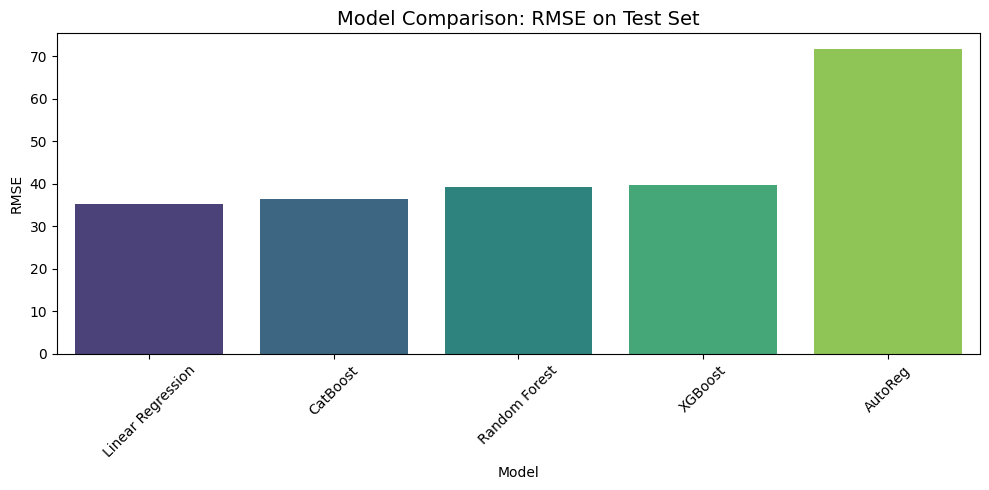

In [43]:
# model comparison, the lower RMSE the better
results = {
    "Linear Regression": 35.22,
    "CatBoost": 36.45,
    "Random Forest": 39.26,
    "XGBoost": 39.59,
    "AutoReg": 71.78
}

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE'])
results_df = results_df.sort_values("RMSE")

plt.figure(figsize=(10,5))
sns.barplot(x=results_df.index, y=results_df['RMSE'], palette="viridis")
plt.title("Model Comparison: RMSE on Test Set", fontsize=14)
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

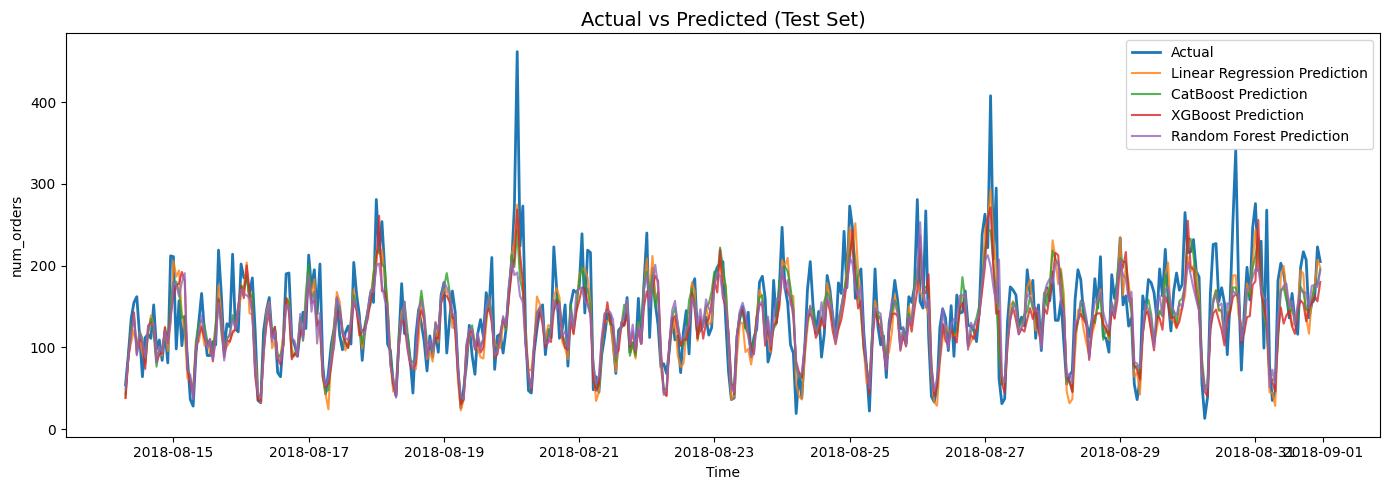

In [44]:
#Prediction vs Actual values
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, lr_pred, label="Linear Regression Prediction", alpha=0.8)
plt.plot(y_test.index, cb_pred, label="CatBoost Prediction", alpha=0.8)
plt.plot(y_test.index, xgb_pred, label="XGBoost Prediction", alpha=0.8)
plt.plot(y_test.index, rf_pred, label="Random Forest Prediction", alpha=0.8)

plt.title("Actual vs Predicted (Test Set)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("num_orders")
plt.legend()
plt.tight_layout()
plt.show()

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Reviewer's comment v1</b>
 
Well done!

# Conclusions

After evaluating several models on the hourly taxi demand dataset, we obtained the following RMSE values:

| Model              | RMSE   |
|--------------------|--------|
| Linear Regression  | 35.22  |
| CatBoost           | 36.45  |
| Random Forest      | 39.26  |
| XGBoost            | 39.59  |
| AutoReg            | 71.78  |

### 1. Linear Regression performs the best
Linear Regression achieved the lowest RMSE (35.22). This suggests that after adding time-based features (lags, rolling means, hour/day/week indicators), the patterns in the data become largely linear. Because of this, a simple linear model can outperform more complex nonlinear methods.

### 2. Tree-based models do not improve accuracy
CatBoost, XGBoost, and Random Forest performed well but did not surpass Linear Regression. This indicates that:
- Nonlinear patterns in the data are limited.
- The engineered features already capture the important structure.
- More complex models tend to overfit the noise in hourly taxi demand.

### 3. AutoReg performs the worst
AutoReg produced a much higher RMSE (71.78). This is expected because AutoReg uses only past values of the target and does not use calendar features or rolling statistics, making it unable to capture daily and weekly seasonality effectively.

### 4. Feature engineering is the main reason for strong performance
The inclusion of lag features, rolling means, and calendar variables successfully captured:
- Daily seasonality (24 hours)
- Weekly seasonality (168 hours)
- Short-term trends
- Long-term trends

These features significantly improved the performance of all ML models.

### 5. All machine learning models meet the project requirement
The requirement was RMSE ≤ 48. Four out of five models met this requirement comfortably, confirming that the modeling pipeline is successful.

### Final Recommendation
The best model for this task is Linear Regression. It is accurate, simple, fast, and easy to interpret. Additional external features such as weather or holidays could further improve performance in the future.


<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Reviewer's comment v1</b>
 
Amazing project!

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48